In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

from sklearn.svm import SVC

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from tqdm import tqdm
import pickle

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Standardize Data
def standardize_data(train, test):
    """ Function to standardize data that's been split into a train and test set
        param:
            train: training data
            test: testing data
    """
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train)
    test_scaled = scaler.transform(test)
    return train_scaled, test_scaled, scaler

In [3]:
def prediction_outputs(y, y_predictions, y_predictions_prob):
    # Confusion Matrix
    conf_mat = confusion_matrix(y, y_predictions)
    
    # ROC Curve
    basic_falpos, basic_trupos, _ = roc_curve(y, [0 for _ in range(len(y))])
    pred_falpos, pred_trupos, pred_thresholds = roc_curve(y, y_predictions_prob)
    
    # Precision Recall
    precision, recall, pr_thresholds = precision_recall_curve(y, y_predictions_prob)
    
    outputs = {
        'conf_mat': conf_mat,
        'basic_falpos': basic_falpos,
        'basic_trupos': basic_trupos,
        'pred_falpos': pred_falpos,
        'pred_trupos': pred_trupos,
        'pred_thresholds': pred_thresholds,
        'precision': precision,
        'recall': recall,
        'pr_thresholds': pr_thresholds
    }
    
    return outputs

In [4]:
# Logit Model
def logit_model(x_train, y_train, x_test, y_test, penalty = 'none', standardize = True):
    if standardize:
        x_train, x_test, _ = standardize_data(x_train, x_test)
    
    model = LogisticRegression(penalty = penalty).fit(x_train, y_train)
    
    train_acc = accuracy_score(y_train, model.predict(x_train))
    test_acc = accuracy_score(y_test, model.predict(x_test))

    train_acc_bal = balanced_accuracy_score(y_train, model.predict(x_train))
    test_acc_bal = balanced_accuracy_score(y_test, model.predict(x_test))    
    
    y_predictions = model.predict(x_train)
    y_predictions_prob = model.predict_proba(x_train)[:, 1]    
    train_pred_out = prediction_outputs(y_train, y_predictions, y_predictions_prob)

    y_predictions = model.predict(x_test)
    y_predictions_prob = model.predict_proba(x_test)[:, 1]    
    test_pred_out = prediction_outputs(y_test, y_predictions, y_predictions_prob)
    
    outputs = {
        'train_acc': train_acc,
        'test_acc': test_acc,
        'train_acc_bal': train_acc_bal,
        'test_acc_bal': test_acc_bal,        
        'train_conf_mat': train_pred_out['conf_mat'],
        'test_conf_mat': test_pred_out['conf_mat'],
        'train_basic_roc': (train_pred_out['basic_falpos'], train_pred_out['basic_trupos']),
        'train_log_roc': (train_pred_out['pred_falpos'], train_pred_out['pred_trupos'], train_pred_out['pred_thresholds']),
        'train_precision': (train_pred_out['precision'], train_pred_out['recall'], train_pred_out['pr_thresholds']),
        'test_basic_roc': (test_pred_out['basic_falpos'], test_pred_out['basic_trupos']),
        'test_log_roc': (test_pred_out['pred_falpos'], test_pred_out['pred_trupos'], test_pred_out['pred_thresholds']),
        'test_precision': (test_pred_out['precision'], test_pred_out['recall'], test_pred_out['pr_thresholds']),
    }
    
    return outputs

In [5]:
# Support Vector Machines
def svm_model(x_train, y_train, x_test, y_test, standardize = True, scoring = 'balanced_accuracy', test = True, folds = 5):
    if test:
        hyperparameters = [
            {'kernel': ['linear']},
            {'kernel': ['poly'], 'degree': [2]},
            {'kernel': ['rbf'], 'gamma': [0.01]}
        ]    
    else:
        #C = [0.001, 0.01, 0.1, 1, 10, 100]
        C = [0.1, 1, 10]

        hyperparameters = [
            {'kernel': ['linear'], 'C': C},
            {'kernel': ['poly'], 'degree': [2, 3, 4], 'C': C},
            {'kernel': ['rbf'], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1], 'C': C}
        ]
    
    if standardize:
        x_train, x_test, _ = standardize_data(x_train, x_test)

    svm_model = SVC(probability = True)
    stratKFold = StratifiedKFold(n_splits = folds)
    
    grid = GridSearchCV(svm_model, hyperparameters, cv = stratKFold, scoring = scoring, verbose = 2, n_jobs = -1)
    model = grid.fit(x_train, y_train)
    
    train_acc = accuracy_score(y_train, model.predict(x_train))
    test_acc = accuracy_score(y_test, model.predict(x_test))

    train_acc_bal = balanced_accuracy_score(y_train, model.predict(x_train))
    test_acc_bal = balanced_accuracy_score(y_test, model.predict(x_test))    
    
    y_predictions = model.predict(x_train)
    y_predictions_prob = model.predict_proba(x_train)[:, 1]    
    train_pred_out = prediction_outputs(y_train, y_predictions, y_predictions_prob)

    y_predictions = model.predict(x_test)
    y_predictions_prob = model.predict_proba(x_test)[:, 1]    
    test_pred_out = prediction_outputs(y_test, y_predictions, y_predictions_prob)
    
    outputs = {
        'best_params': model.best_params_,
        'model': model,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'train_acc_bal': train_acc_bal,
        'test_acc_bal': test_acc_bal,        
        'train_conf_mat': train_pred_out['conf_mat'],
        'test_conf_mat': test_pred_out['conf_mat'],
        'train_basic_roc': (train_pred_out['basic_falpos'], train_pred_out['basic_trupos']),
        'train_log_roc': (train_pred_out['pred_falpos'], train_pred_out['pred_trupos'], train_pred_out['pred_thresholds']),
        'train_precision': (train_pred_out['precision'], train_pred_out['recall'], train_pred_out['pr_thresholds']),
        'test_basic_roc': (test_pred_out['basic_falpos'], test_pred_out['basic_trupos']),
        'test_log_roc': (test_pred_out['pred_falpos'], test_pred_out['pred_trupos'], test_pred_out['pred_thresholds']),
        'test_precision': (test_pred_out['precision'], test_pred_out['recall'], test_pred_out['pr_thresholds']),
    }
    
    return outputs

In [6]:
# Neural Networks
# Build neural network based on parameters passed in
def build_NN(num_classes, hidden_layers, neurons_per_layer, dropout_rate, input_dimensions):
    model = Sequential()
    model.add(Dense(neurons_per_layer, input_dim = input_dimensions, activation = 'relu'))

    for i in range(hidden_layers):
        model.add(Dense(neurons_per_layer, activation = 'relu'))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))

    model.add(Dense(num_classes, activation = 'softmax'))

    model.compile(
        loss = 'categorical_crossentropy',
        optimizer = 'adam',
        metrics = ['accuracy']
    )
    
    return model

def neural_network_model(x_train, y_train, x_test, y_test, standardize = True, scoring = 'balanced_accuracy', test = True,
                         folds = 5):
    if test:
        hyperparameters = {
            'hidden_layers': [1],
            'neurons_per_layer': [32, 64],
            'dropout_rate': [0],
            'batch_size': [32],
            'epochs': [20]
        }
    else:
        dropout_rates = [0, 0.1, 0.2, 0.3]
        batch_size = [32]
        epochs = [20]
        hyperparameters = [
            {
                'hidden_layers': [1],
                'neurons_per_layer': [32, 64, 128, 256, 512, 1028],
                'dropout_rate': dropout_rates,
                'batch_size': batch_size,
                'epochs': epochs,
            },
            {
                'hidden_layers': [2],
                'neurons_per_layer': [32, 64, 128, 256, 512],
                'dropout_rate': dropout_rates,
                'batch_size': batch_size,
                'epochs': epochs
            },
            {
                'hidden_layers': [3],
                'neurons_per_layer': [32, 64, 128, 256],
                'dropout_rate': dropout_rates,
                'batch_size': batch_size,
                'epochs': epochs
            }
        ]
    
    if standardize:
        x_train, x_test, _ = standardize_data(x_train, x_test)

    num_classes = max(y_train)+1
    input_dimensions = x_train.shape[1]
    
    nn_model = KerasClassifier(build_fn = build_NN, num_classes = num_classes, input_dimensions = input_dimensions)
    stratKFold = StratifiedKFold(n_splits = folds)
    
    grid = GridSearchCV(nn_model, hyperparameters, cv = stratKFold, scoring = scoring, verbose = 2, n_jobs = -1)
    model = grid.fit(x_train, y_train)
    
    train_predictions = model.predict(x_train)
    test_predictions = model.predict(x_test)
    
    train_acc = accuracy_score(y_train, train_predictions)
    test_acc = accuracy_score(y_test, test_predictions)

    train_acc_bal = balanced_accuracy_score(y_train, train_predictions)
    test_acc_bal = balanced_accuracy_score(y_test, test_predictions)
    
    y_predictions_prob = model.predict_proba(x_train)[:, 1]    
    train_pred_out = prediction_outputs(y_train, train_predictions, y_predictions_prob)

    y_predictions_prob = model.predict_proba(x_test)[:, 1]    
    test_pred_out = prediction_outputs(y_test, test_predictions, y_predictions_prob)
    
    outputs = {
        'best_params': model.best_params_,
        'model': model,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'train_acc_bal': train_acc_bal,
        'test_acc_bal': test_acc_bal,        
        'train_conf_mat': train_pred_out['conf_mat'],
        'test_conf_mat': test_pred_out['conf_mat'],
        'train_basic_roc': (train_pred_out['basic_falpos'], train_pred_out['basic_trupos']),
        'train_log_roc': (train_pred_out['pred_falpos'], train_pred_out['pred_trupos'], train_pred_out['pred_thresholds']),
        'train_precision': (train_pred_out['precision'], train_pred_out['recall'], train_pred_out['pr_thresholds']),
        'test_basic_roc': (test_pred_out['basic_falpos'], test_pred_out['basic_trupos']),
        'test_log_roc': (test_pred_out['pred_falpos'], test_pred_out['pred_trupos'], test_pred_out['pred_thresholds']),
        'test_precision': (test_pred_out['precision'], test_pred_out['recall'], test_pred_out['pr_thresholds']),
    }
    
    return outputs

In [7]:
# Random Forests
def random_forest_model(x_train, y_train, x_test, y_test, standardize = True, scoring = 'balanced_accuracy', test = True, folds = 5):
    if test:
        hyperparameters = dict(
            n_estimators = [100, 200, 300],
            max_depth = [3],
            max_samples = [0.2],
            max_features = ['auto'],
            min_samples_leaf = [5e-05],
            ccp_alpha = [0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006]
        )
    else:
        #hyperparameters = dict(
        #    n_estimators=[100, 200, 300],
        #    max_depth=[3, 4, 5],
        #    max_samples=[0.2, 0.4, 0.6],
        #    max_features=['auto'],
        #    min_samples_leaf=[5e-05, 0.0001, 0.0005, 0.001],
        #    ccp_alpha=[0.006, 0.012, 0.03, 0.05]
        #)
        new = {
            'n_estimators': [100, 200, 300],
            'max_depth': [2, 3, 4, 5, 6, 8, 10],
            'max_samples': [0.05, 0.1, 0.2, 0.4, 0.6],
            'max_features': ['auto'],
            'min_samples_leaf': [1e-05, 5e-05, 0.0001, 0.0005, 0.001],
            'ccp_alpha': [0, 0.0015, 0.003, 0.006, 0.012, 0.03, 0.05]
        }

        old = {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 4, 5],
            'max_samples': [0.2, 0.4, 0.6],
            'max_features': ['auto'],
            'min_samples_leaf': [5e-05, 0.0001, 0.0005, 0.001],
            'ccp_alpha': [0.006, 0.012, 0.03, 0.05]
        }
        
        hyperparameters = []

        for n_est in new['n_estimators']:
            for max_depth in new['max_depth']:
                for max_samples in new['max_samples']:
                    for min_samples_leaf in new['min_samples_leaf']:
                        for ccp_alpha in new['ccp_alpha']:
                            if (n_est in old['n_estimators']) and (max_depth in old['max_depth']) and (max_samples in old['max_samples']) and (min_samples_leaf in old['min_samples_leaf']) and (ccp_alpha in old['ccp_alpha']):
                                continue
                            else:
                                hyperparameters.append({
                                    'n_estimators': [n_est],
                                    'max_depth': [max_depth],
                                    'max_samples': [max_samples],
                                    'max_features': ['auto'],
                                    'min_samples_leaf': [min_samples_leaf],
                                    'ccp_alpha': [ccp_alpha]
                                })
    
    if standardize:
        x_train, x_test, _ = standardize_data(x_train, x_test)

    rf_model = RandomForestClassifier(n_jobs = -1)
    stratKFold = StratifiedKFold(n_splits = folds)
    
    grid = GridSearchCV(rf_model, hyperparameters, cv = stratKFold, scoring = scoring, verbose = 2, n_jobs = -1)
    model = grid.fit(x_train, y_train)
    
    train_acc = accuracy_score(y_train, model.predict(x_train))
    test_acc = accuracy_score(y_test, model.predict(x_test))

    train_acc_bal = balanced_accuracy_score(y_train, model.predict(x_train))
    test_acc_bal = balanced_accuracy_score(y_test, model.predict(x_test))    
    
    y_predictions = model.predict(x_train)
    y_predictions_prob = model.predict_proba(x_train)[:, 1]    
    train_pred_out = prediction_outputs(y_train, y_predictions, y_predictions_prob)

    y_predictions = model.predict(x_test)
    y_predictions_prob = model.predict_proba(x_test)[:, 1]    
    test_pred_out = prediction_outputs(y_test, y_predictions, y_predictions_prob)
    
    outputs = {
        'best_params': model.best_params_,
        'model': model,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'train_acc_bal': train_acc_bal,
        'test_acc_bal': test_acc_bal,        
        'train_conf_mat': train_pred_out['conf_mat'],
        'test_conf_mat': test_pred_out['conf_mat'],
        'train_basic_roc': (train_pred_out['basic_falpos'], train_pred_out['basic_trupos']),
        'train_log_roc': (train_pred_out['pred_falpos'], train_pred_out['pred_trupos'], train_pred_out['pred_thresholds']),
        'train_precision': (train_pred_out['precision'], train_pred_out['recall'], train_pred_out['pr_thresholds']),
        'test_basic_roc': (test_pred_out['basic_falpos'], test_pred_out['basic_trupos']),
        'test_log_roc': (test_pred_out['pred_falpos'], test_pred_out['pred_trupos'], test_pred_out['pred_thresholds']),
        'test_precision': (test_pred_out['precision'], test_pred_out['recall'], test_pred_out['pr_thresholds']),
    }
    
    return outputs

In [8]:
# General Analytics
def train_test_set(data, split_pct = 0.5):
    fraud = data[data['isFraud'] == 1]
    nofraud = data[data['isFraud'] == 0]
    
    fraud_train, fraud_test = train_test_split(fraud, test_size = split_pct)
    nofraud_train, nofraud_test = train_test_split(nofraud, test_size = split_pct)
    
    train = pd.concat([fraud_train, nofraud_train])
    test = pd.concat([fraud_test, nofraud_test])
    
    x_train = train.values[:,:-1]
    y_train = train.values[:,-1]

    x_test = test.values[:,:-1]
    y_test = test.values[:,-1]
    
    return x_train, y_train, x_test, y_test

In [9]:
# Plotting Functions
def plot_roc(no_skill_in, other_predictions, title = ''):
    plt.plot(no_skill['false_pos'], no_skill['true_pos'], label = 'No Skill')
    for other_pred in other_predictions:
        plt.plot(other_pred['false_pos'], other_pred['true_pos'], label = other_pred['label'])
        
    plt.xlabel('False Positive Rate (FP / (FP + TN))')
    plt.ylabel('True Positive Rate (TP / (TP + FN))')
    if title != '':
        plt.title(title)
    
    plt.legend()
    plt.show()
    
    return None

def plot_pr(other_predictions, title = ''):
    for other_pred in other_predictions:
        plt.plot(other_pred['precision'], other_pred['recall'], label = other_pred['label'])
        
    plt.xlabel('Precision (TP / (TP + FP))')
    plt.ylabel('Recall (TP / (TP + FN))')
    if title != '':
        plt.title(title)
    
    plt.legend()
    plt.show()
    
    return None

In [10]:
fraud_data = pd.read_csv('PS_data.csv')
fraud_data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [12]:
# Only taking the first 100,000 rows
fraud_data = fraud_data.iloc[0:100000]

In [13]:
# Only taking a few of the columns
col_subset = ['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','isFraud']
x_train, y_train, x_test, y_test = train_test_set(fraud_data[col_subset], split_pct = 0.5)

In [14]:
logit_output = logit_model(x_train, y_train, x_test, y_test, penalty = 'none', standardize = True)
logit_output

{'train_acc': 0.9989,
 'test_acc': 0.99884,
 'train_acc_bal': 0.5516941030906196,
 'test_acc_bal': 0.5172213560834016,
 'train_conf_mat': array([[49939,     3],
        [   52,     6]], dtype=int64),
 'test_conf_mat': array([[49940,     2],
        [   56,     2]], dtype=int64),
 'train_basic_roc': (array([0., 1.]), array([0., 1.])),
 'train_log_roc': (array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.00696808e-05,
         6.00696808e-05, 1.40162589e-04, 1.40162589e-04, 4.40510993e-04,
         4.40510993e-04, 4.80557447e-04, 4.80557447e-04, 8.40975532e-04,
         8.40975532e-04, 8.81021986e-04, 8.81021986e-04, 1.10127748e-03,
         1.10127748e-03, 1.20139362e-03, 1.20139362e-03, 1.56181170e-03,
         1.56181170e-03, 2.40278723e-03, 2.40278723e-03, 3.28380922e-03,
         3.28380922e-03, 5.14596932e-03, 5.14596932e-03, 6.48752553e-03,
         6.48752553e-03, 6.50754876e-03, 6.50754876e-03, 6.58764166e-03,
         6.58764166e-03, 8.63001081e-03, 8.63001081e-03, 9.7112

In [15]:
test_mode = True
cv_folds = 3
scoring_metric = 'roc_auc'

In [16]:
svm_output = svm_model(x_train, y_train, x_test, y_test, standardize = True, scoring = scoring_metric,
                       test = test_mode, folds = cv_folds)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [17]:
# svm_output

In [18]:
# pd.DataFrame(svm_output['best_params'].items()).to_csv('svm_params.csv')

In [19]:
rf_output = random_forest_model(x_train, y_train, x_test, y_test, standardize = True, scoring = scoring_metric,
                                test = test_mode, folds = cv_folds)

Fitting 3 folds for each of 21 candidates, totalling 63 fits


In [20]:
# rf_output

In [21]:
# pd.DataFrame(rf_output['best_params'].items()).to_csv('random_forest_params.csv')

In [23]:
nn_output = neural_network_model(x_train, y_train, x_test, y_test, standardize = True, scoring = scoring_metric,
                                 test = test_mode, folds = cv_folds)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Epoch 1/20
1563/1563 [==============================] - 3s 1ms/step - loss: 0.0222 - accuracy: 0.9988
Epoch 2/20
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0089 - accuracy: 0.9988
Epoch 3/20
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0084 - accuracy: 0.9989
Epoch 4/20
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0083 - accuracy: 0.9989
Epoch 5/20
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0080 - accuracy: 0.9989
Epoch 6/20
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0081 - accuracy: 0.9988
Epoch 7/20
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0080 - accuracy: 0.9989
Epoch 8/20
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0077 - accuracy: 0.9989
Epoch 9/20
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0076 - accuracy: 0.9989
Epoch 10/20
1563/1563 [

In [ ]:
# nn_output

In [ ]:
# pd.DataFrame(nn_output['best_params'].items()).to_csv('neural_network_params_2.csv')

#### ROC

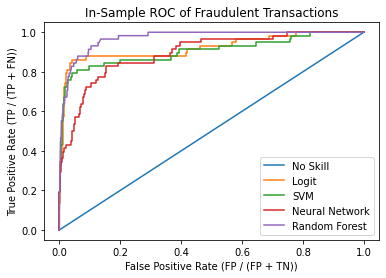

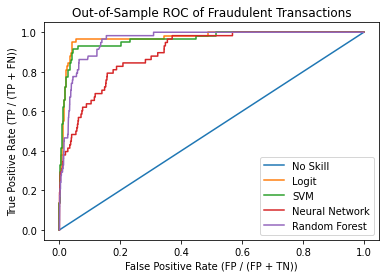

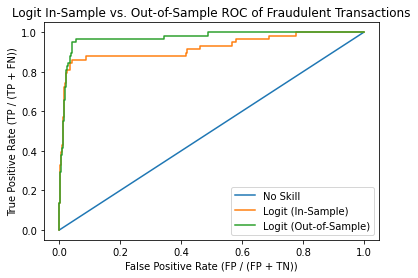

In [24]:
no_skill = {'false_pos': logit_output['train_basic_roc'][0], 'true_pos': logit_output['train_basic_roc'][1]}
other_predictions = [
    {'false_pos': logit_output['train_log_roc'][0], 'true_pos': logit_output['train_log_roc'][1], 'label': 'Logit'},
    {'false_pos': svm_output['train_log_roc'][0], 'true_pos': svm_output['train_log_roc'][1], 'label': 'SVM'},
    {'false_pos': nn_output['train_log_roc'][0], 'true_pos': nn_output['train_log_roc'][1], 'label': 'Neural Network'},
    {'false_pos': rf_output['train_log_roc'][0], 'true_pos': rf_output['train_log_roc'][1], 'label': 'Random Forest'}
]

plot_roc(no_skill, other_predictions, title = 'In-Sample ROC of Fraudulent Transactions')

no_skill = {'false_pos': logit_output['test_basic_roc'][0], 'true_pos': logit_output['test_basic_roc'][1]}
other_predictions = [
    {'false_pos': logit_output['test_log_roc'][0], 'true_pos': logit_output['test_log_roc'][1], 'label': 'Logit'},
    {'false_pos': svm_output['test_log_roc'][0], 'true_pos': svm_output['test_log_roc'][1], 'label': 'SVM'},
    {'false_pos': nn_output['test_log_roc'][0], 'true_pos': nn_output['test_log_roc'][1], 'label': 'Neural Network'},
    {'false_pos': rf_output['test_log_roc'][0], 'true_pos': rf_output['test_log_roc'][1], 'label': 'Random Forest'}
]

plot_roc(no_skill, other_predictions, title = 'Out-of-Sample ROC of Fraudulent Transactions')

no_skill = {'false_pos': logit_output['test_basic_roc'][0], 'true_pos': logit_output['test_basic_roc'][1]}
other_predictions = [
    {'false_pos': logit_output['train_log_roc'][0], 'true_pos': logit_output['train_log_roc'][1], 'label': 'Logit (In-Sample)'},
    {'false_pos': logit_output['test_log_roc'][0], 'true_pos': logit_output['test_log_roc'][1], 'label': 'Logit (Out-of-Sample)'},
]

plot_roc(no_skill, other_predictions, title = 'Logit In-Sample vs. Out-of-Sample ROC of Fraudulent Transactions')

#### Precision Recall

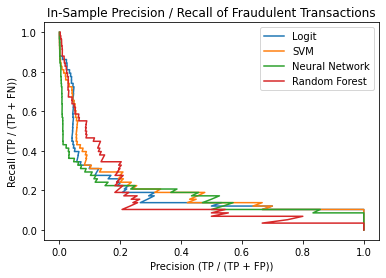

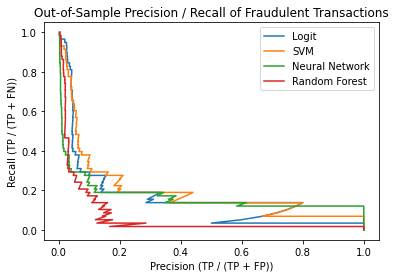

In [25]:
other_predictions = [
    {'precision': logit_output['train_precision'][0], 'recall': logit_output['train_precision'][1], 'label': 'Logit'},
    {'precision': svm_output['train_precision'][0], 'recall': svm_output['train_precision'][1], 'label': 'SVM'},
    {'precision': nn_output['train_precision'][0], 'recall': nn_output['train_precision'][1], 'label': 'Neural Network'},
    {'precision': rf_output['train_precision'][0], 'recall': rf_output['train_precision'][1], 'label': 'Random Forest'},
]

plot_pr(other_predictions, title = 'In-Sample Precision / Recall of Fraudulent Transactions')

other_predictions = [
    {'precision': logit_output['test_precision'][0], 'recall': logit_output['test_precision'][1], 'label': 'Logit'},
    {'precision': svm_output['test_precision'][0], 'recall': svm_output['test_precision'][1], 'label': 'SVM'},
    {'precision': nn_output['test_precision'][0], 'recall': nn_output['test_precision'][1], 'label': 'Neural Network'},
    {'precision': rf_output['test_precision'][0], 'recall': rf_output['test_precision'][1], 'label': 'Random Forest'},
]

plot_pr(other_predictions, title = 'Out-of-Sample Precision / Recall of Fraudulent Transactions')